<a href="https://colab.research.google.com/github/liuxx479/NGphotoz/blob/master/prep_raytrace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from pylab import *
from scipy.stats import norm

%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/drive')
root = '/content/drive/My Drive/NGphotoz/'

Mounted at /content/drive


In [3]:
########### code from MMR

class PhotoZ_core(object):
    """Defines p(zp | z) of the core distribution (i.e. no outliers)
    """

    def __init__(self, zp_support, zbias, sigma_z):
        self.zp_support = zp_support
        self.zbias = zbias
        self.sigma_z = sigma_z

    def get_pdf_given(self, z):
        assert np.isscalar(z)
        rv = norm()
        scale = self.sigma_z * (1. + z)
        loc = z - self.zbias
        return rv.pdf((self.zp_support - loc) / scale) / scale


class PhotoZ_outlier(object):
    """ Define a gaussian distributed
    outlier population

    """
    def __init__(self, zp_support, z_cat, sigma_cat):
        self.z_cat = z_cat
        self.sigma_cat = sigma_cat
        self.zp_support = zp_support

    def get_pdf_given(self, z):
        assert np.isscalar(z)
        rv = norm()
        return rv.pdf((self.zp_support - self.z_cat) / self.sigma_cat) / self.sigma_cat


class PhotoZ_outlier_position(object):
    """ Define the position and fraction of
    the outlier populations for both the
    Lyman-Alpha and Balmer Breaks
    """
    def __init__(self, F_cat, delta_z_cat, z_cat_position):
        assert np.isscalar(F_cat)
        self.delta_z_cat = delta_z_cat
        self.z_cat_position = z_cat_position
        self.F_cat = F_cat

    def get_weight_given(self, z):
        assert np.isscalar(z)
        if (z > self.z_cat_position - self.delta_z_cat) and (z < self.z_cat_position + self.delta_z_cat):
            return self.F_cat
        else:
            return 0.


class LymanBalmerConfusion(object):
    """ We fix here the position of the
        Lyman-Balmer Confusion (maybe we need to adjust this)
        But this should be ok for now
    """
    def __init__(self, zp_support):
        self.outlier_pdf = PhotoZ_outlier(zp_support, z_cat=3.75, sigma_cat=0.25)

    def get_pdf_given(self, z):
        # Note this pdf is normalized to F_cat or zero!!!
        assert np.isscalar(z)
        outlier_pdf = self.outlier_pdf.get_pdf_given(z)
        return outlier_pdf


class LymanAlphaBalmerConfusion(object):
    """ We fix here the position of the
        LymanAlpha - Balmer Confusion (maybe we need to adjust this)
    """
    def __init__(self, zp_support):
        self.outlier_pdf = PhotoZ_outlier(zp_support, z_cat=0.5, sigma_cat=0.25)

    def get_pdf_given(self, z):
        # Note this pdf is normalized to F_cat or zero!!!
        assert np.isscalar(z)
        outlier_pdf = self.outlier_pdf.get_pdf_given(z)
        return outlier_pdf


class CoreAndOutlier(object):
    """
    Defines the core and outlier population

    """
    def __init__(self, zp_support, zbias, sigma_z, F_cat_lyman_balmer, F_cat_lyman_alpha_balmer):
        if sigma_z < 0.01:
            raise ValueError("Choosing a `close to delta' function as the conditional leads to numerical problems on a fixed grid!")
        self.zp_support = zp_support
        self.core = PhotoZ_core(zp_support, zbias, sigma_z)

        self.pos_lyman_balmer = PhotoZ_outlier_position(F_cat_lyman_balmer,
                                                        delta_z_cat=0.25, z_cat_position=0.25)
        self.lyman_balmer = LymanBalmerConfusion(zp_support)

        self.pos_lyman_alpha_balmer = PhotoZ_outlier_position(F_cat_lyman_alpha_balmer,
                                                              delta_z_cat=0.25, z_cat_position=3.)
        self.lyman_alpha_balmer = LymanAlphaBalmerConfusion(zp_support)

    def get_pdf_given(self, z):
        assert np.isscalar(z)
        weight_lyman_balmer = self.pos_lyman_balmer.get_weight_given(z)
        weight_lyman_alpha_balmer = self.pos_lyman_alpha_balmer.get_weight_given(z)
        weight_core = 1.0 - weight_lyman_balmer - weight_lyman_alpha_balmer
        # print(weight_core)
        core_pdf = self.core.get_pdf_given(z)
        core_pdf = core_pdf / np.trapz(core_pdf, self.zp_support)

        lyman_balmer_outliers = self.lyman_balmer.get_pdf_given(z)
        lyman_balmer_outliers = lyman_balmer_outliers / np.trapz(lyman_balmer_outliers, self.zp_support)

        lyman_alpha_balmer_outliers = self.lyman_alpha_balmer.get_pdf_given(z)
        lyman_alpha_balmer_outliers = lyman_alpha_balmer_outliers / np.trapz(lyman_alpha_balmer_outliers,
                                                                             self.zp_support)

        cond_pdf = weight_core * core_pdf + weight_lyman_balmer * lyman_balmer_outliers + weight_lyman_alpha_balmer * lyman_alpha_balmer_outliers
        return cond_pdf


class SmailZ(object):
    """ Define the True photometric redshift distribution
    that follows a Smail Type distribution
    """
    def __init__(self, z_support, z0, gamma, alpha):
        pdf = z_support ** alpha * np.exp(-(z_support / z0) ** (gamma))
        self.z_support = z_support
        self.pdf = pdf / np.trapz(pdf, z_support)

    def get_pdf(self):
        return self.pdf

    def get_pdf_convoled(self, filter_list):
        output_tomo_list = []
        for el in filter_list:
            output_tomo_list.append(el * self.pdf)
        output_tomo_list = np.array(output_tomo_list).T
        output_tomo_list = np.column_stack((self.z_support, output_tomo_list))
        return output_tomo_list


class PhotozModel(object):
    """Convolve the joint distribution p(z_s, z_p) with
    a set of filter functions (e.g. gaussian or tophat)

    The class function get_pdf produces an array of tomographic
    bins

    """
    def __init__(self, pdf_z, pdf_zphot_given_z, filters):
        self.pdf_zphot_given_z = pdf_zphot_given_z
        self.pdf_z = pdf_z
        self.filter_list = filters

    def normalize(self, pz):
        for i in range(pz.shape[1]):
            pz[:, i] = pz[:, i]/np.trapz(pz[:, i], self.pdf_zphot_given_z.zp_support)

        return pz

    def get_pdf(self):
        tomo_collect = []
        for el in self.filter_list:
            tomo_pdf = self.get_pdf_tomo(el)

            tomo_collect.append(tomo_pdf)

        tomo_collect = np.array(tomo_collect).T
        tomo_collect = self.normalize(tomo_collect)
        return tomo_collect

    def get_pdf_tomo(self, filter):
        z_support = self.pdf_z.z_support
        zp_support = self.pdf_zphot_given_z.zp_support
        z_pdf = self.pdf_z.get_pdf()
        pdf_joint = np.zeros((len(zp_support), len(z_support)))
        for i in range(len(z_support)):
            pdf_joint[:, i] = self.pdf_zphot_given_z.get_pdf_given(z_support[i]) * z_pdf[i] * filter[i]

        pdf_zp = np.zeros((len(zp_support),))
        for i in range(len(zp_support)):
            pdf_zp[i] = np.trapz(pdf_joint[i, :], z_support)

        return pdf_zp

In [31]:
######## JL test Joachim's Pz against LSST SB Pz

def Pz_norm(zp_support, pz):
  return pz/np.trapz(pz, zp_support)

def Pz_norm_tomo(zp_support, pz):
  for i in range(pz.shape[1]):
      pz[:, i] = pz[:, i]/np.trapz(pz[:, i], zp_support)
  return pz

######### LSST SB Pz
Mlim = 25.3 ## gold sample
z0_SB = 0.0417*Mlim-0.744
Pz_SB = lambda z: 0.5/z0_SB**3 * z**2 * exp(-z/z0_SB)
print (z0_SB)

####### LSST SRD Y10 numbers
z0_SRD=0.28
alpha_SRD=0.9
Pz_SRD = lambda z: z**2 * exp(-(z/z0_SRD)**alpha_SRD)

zarr=np.linspace(0,4, 100)

######## Joachim's Pz
Pz_JH = np.array([np.loadtxt(root+'pz/zdist_sources_bin%i.txt'%(i)) for i in range(5)])
zarr_JH = Pz_JH[0,:,0]
print (Pz_JH.shape)
Pz_JH_all = Pz_norm(zarr_JH, sum(Pz_JH[:,:,1], axis=0))

0.31101
(5, 300, 2)


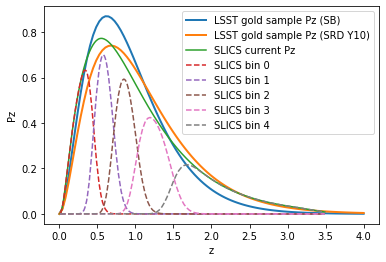

In [32]:
### plot
Pz_SB = Pz_norm(zarr, Pz_SB(zarr))
plot(zarr, Pz_SB, lw=2, label='LSST gold sample Pz (SB)')

Pz_SRD = Pz_norm(zarr, Pz_SRD(zarr))
plot(zarr, Pz_SRD, lw=2, label='LSST gold sample Pz (SRD Y10)')

plot(zarr_JH, Pz_JH_all, label='SLICS current Pz')
for i in range(5):
  ipz = Pz_norm(zarr_JH, Pz_JH[i,:,1])
  plot(zarr_JH, ipz/5, '--',label='SLICS bin %i'%(i))
xlabel('z')
ylabel('Pz')
legend()
show()

In [33]:
# Pz_JH[:,:,0]